<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

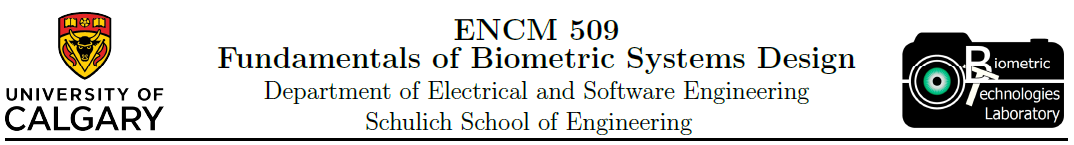

# ENCM 509 - Speaker Recognition Final Project

**Student Names**


**Mushtaba Al Yasseen (30094000)**
\
**Abhay Khosla (30085789)**
\
**Parbir Lehal ()**

In [67]:
# Packages 
import numpy as np
from python_speech_features import mfcc
from sklearn.mixture import GaussianMixture
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.stats import norm

In [68]:
NUMOFTRAININGSAMPLES = 8  # Number of samples to test

# Directory containing the testing/training data files
realData = "./TrumpReal/"
donaldTrumpTrainingPaths = [f"{realData}{i}.wav" for i in range(1, NUMOFTRAININGSAMPLES + 1)]  
donaldTrumpTestingPaths = [f"{realData}{i}.wav" for i in range(NUMOFTRAININGSAMPLES + 1, 11)]
donaldTrumpAIPaths = [f"./TrumpAI/{i}.wav" for i in range(1, 11)]
print(len(donaldTrumpTrainingPaths))
print(len(donaldTrumpTestingPaths))
print(len(donaldTrumpAIPaths))

8
2
10


### Donald Trump Training Data GMM Model Creation

In [69]:
# create a GMM with n components
n = 20
gmm = GaussianMixture(n_components=n)

mfcc_features = None 
for file_path in donaldTrumpTrainingPaths:
    sample_rate, audio_data = wavfile.read(file_path)
    # compute MFCC features for the audio data
    mfcc_data = mfcc(audio_data, samplerate=sample_rate)
    
    # concatenate the MFCC features into a single numpy array
    if mfcc_features is None:
        mfcc_features = mfcc_data
    else:
        mfcc_features = np.concatenate((mfcc_features, mfcc_data), axis=0)
print(mfcc_features[0])

C:\Users\abhay\AppData\Local\Temp\ipykernel_6784\2289376163.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(file_path)


[-3.60436534e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.65853322e-14  0.00000000e+00  6.86433890e-14  0.00000000e+00
  7.68197924e-14  0.00000000e+00  6.74820084e-14  0.00000000e+00
  3.50716881e-14]


In [70]:
gmm.fit(mfcc_features)

GaussianMixture(n_components=20)

### Donald Trump AI GMM Scoring

In [81]:
donaldTrumpAIScores = []
for donaldTrumpAIPath in donaldTrumpAIPaths:
    sample_rate, test_data = wavfile.read(donaldTrumpAIPath)
    mfcc_data = mfcc(test_data, sample_rate) 
    score = gmm.score(mfcc_data)  # Calculate score
    donaldTrumpAIScores.append(score)  # Append the score for this recording
donaldTrumpAIScores.extend(donaldTrumpAIScores)
print(donaldTrumpAIScores)  

[-47.25106881699593, -47.35176302124236, -47.514431289022, -47.07971270835171, -47.20429360697252, -47.1180495648579, -47.3056006279181, -47.674193970906266, -47.28388922712286, -47.193320797496895, -47.25106881699593, -47.35176302124236, -47.514431289022, -47.07971270835171, -47.20429360697252, -47.1180495648579, -47.3056006279181, -47.674193970906266, -47.28388922712286, -47.193320797496895]


### Donald Trump Real Speech GMM Scoring

In [80]:
donaldTrumpTestScores = []
for donaldTrumpTestingPath in donaldTrumpTestingPaths:
    sample_rate, test_data = wavfile.read(donaldTrumpTestingPath)
    mfcc_data = mfcc(test_data, sample_rate) 
    score = gmm.score(mfcc_data)  # Calculate score
    donaldTrumpTestScores.append(score)  # Append the score for this recording
donaldTrumpTestScores.extend(donaldTrumpTestScores)
print(donaldTrumpTestScores)  

C:\Users\abhay\AppData\Local\Temp\ipykernel_6784\604904164.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, test_data = wavfile.read(donaldTrumpTestingPath)
C:\Users\abhay\AppData\Local\Temp\ipykernel_6784\604904164.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, test_data = wavfile.read(donaldTrumpTestingPath)


[-44.763843818693466, -45.13688780759584, -44.763843818693466, -45.13688780759584]


### Donald Trump Probability Density Function

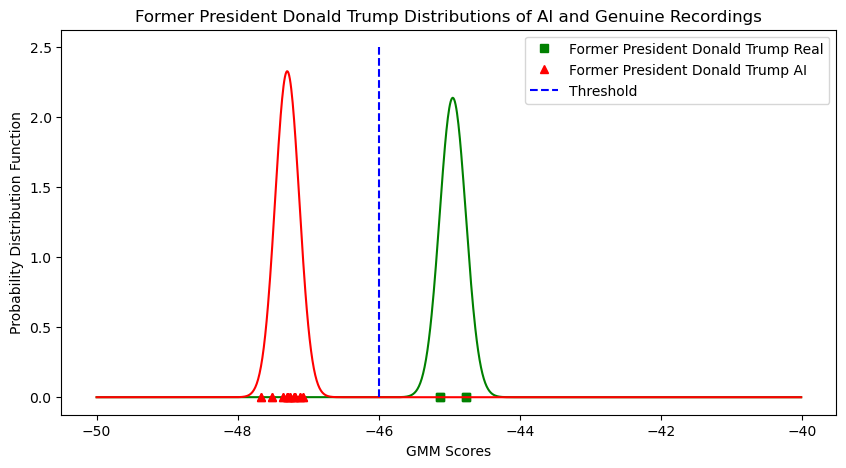

In [79]:
donaldTrumpTotalScore = list(donaldTrumpTestScores)  # Scores from the real data
donaldTrumpTotalScore.extend(donaldTrumpAIScores)  # Scores from the AI-generated data

# Determine the range for x values
lowest_value = min(donaldTrumpTotalScore)
highest_value = max(donaldTrumpTotalScore)

# Generate x values
x = np.arange(-50, -40, 0.01)

# Calculate probability distributions
genuine_dist = norm.pdf(x, loc=np.mean(donaldTrumpTestScores), scale=np.std(donaldTrumpTestScores))
imposter_dist = norm.pdf(x, loc=np.mean(donaldTrumpAIScores), scale=np.std(donaldTrumpAIScores))

threshold = -46

# Plotting
plt.figure(figsize=(10,5))
plt.plot(x, genuine_dist, 'g')
plt.plot(donaldTrumpTestScores, np.zeros(len(donaldTrumpTestScores)), 'gs', lw=2, label='Former President Donald Trump Real')
plt.plot(x, imposter_dist, 'r')
plt.plot(donaldTrumpAIScores, np.zeros(len(donaldTrumpAIScores)), 'r^', lw=2, label='Former President Donald Trump AI')
plt.plot([threshold]*20, np.linspace(0, 2.5, 20), 'b', linestyle = "dashed", label='Threshold')
plt.xlabel("GMM Scores")
plt.ylabel("Probability Distribution Function")
plt.legend()
plt.title('Former President Donald Trump Distributions of AI and Genuine Recordings')
plt.show()